In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
ROOT_PATH='/content/drive/My Drive/Colab Notebooks/learning_ai'
sys.path.append(ROOT_PATH)

Mounted at /content/drive


In [1]:
import sys
ROOT_PATH='.'
sys.path.append(ROOT_PATH)
sys.path.append('/Users/user/.pyenv/versions/3.8.3/lib/python3.8/site-packages/')

In [2]:
from common import config
# config.GPU=True
from common.np import *
from model.unet import Unet
from common.optimizer import *
from common.trainer import Trainer
from common.util import to_cpu,to_gpu
import pickle


with open(ROOT_PATH+'/dataset/illust_ya/illust_ya_train_gray.pkl','rb') as f:
    x_train=pickle.load(f)

with open(ROOT_PATH+'/dataset/illust_ya/illust_ya_train.pkl','rb') as f:
    t_train=pickle.load(f)

with open(ROOT_PATH+'/dataset/illust_ya/illust_ya_test_gray.pkl','rb') as f:
    x_test=pickle.load(f)

with open(ROOT_PATH+'/dataset/illust_ya/illust_ya_test.pkl','rb') as f:
    t_test=pickle.load(f)

x_train=x_train.transpose(0,3,1,2).astype('f')
t_train=t_train.transpose(0,3,1,2).astype('f')

x_test=x_test.transpose(0,3,1,2).astype('f')
t_test=t_test.transpose(0,3,1,2).astype('f')

if GPU:
    x_train=to_gpu(x_train)
    x_test=to_gpu(x_test)
    t_train=to_gpu(t_train)
    t_test=to_gpu(t_test)

x_train/=255.
x_test/=255.
t_train/=255.
t_test/=255.

input_shape=[1,72,72]

conv1_in_list=[
    ['conv',(64,3,3,1,1,2)],['batchnorm',(0.9,None,None)],['relu',()],
    ['conv',(64,3,3,1,1,2)],['batchnorm',(0.9,None,None)],['relu',()]
]

conv2_in_list=[
    ['conv',(128,3,3,1,1,2)],['batchnorm',(0.9,None,None)],['relu',()],
    ['conv',(128,3,3,1,1,2)],['batchnorm',(0.9,None,None)],['relu',()]
]

conv3_in_list=[
    ['conv',(256,3,3,1,1,2)],['batchnorm',(0.9,None,None)],['relu',()],
    ['conv',(256,3,3,1,1,2)],['batchnorm',(0.9,None,None)],['relu',()]
]

conv4_in_list=[
    ['conv',(512,3,3,1,1,2)],['batchnorm',(0.9,None,None)],['relu',()],
    ['conv',(512,3,3,1,1,2)],['batchnorm',(0.9,None,None)],['relu',()]
]

conv_bottom_list=[
    ['conv',(1024,3,3,1,1,2)],['batchnorm',(0.9,None,None)],['relu',()],
    ['conv',(1024,3,3,1,1,2)],['batchnorm',(0.9,None,None)],['relu',()],
    ['deconv',(512,2,2,1,1,2)],['relu',()]
]

conv4_out_list=[
    ['conv',(1024,3,3,1,1,2)],['batchnorm',(0.9,None,None)],['relu',()],
    ['conv',(512,3,3,1,1,2)],['batchnorm',(0.9,None,None)],['relu',()],
    ['deconv',(256,2,2,1,1,2)],['relu',()]
]

conv3_out_list=[
    ['conv',(512,3,3,1,1,2)],['batchnorm',(0.9,None,None)],['relu',()],
    ['conv',(256,3,3,1,1,2)],['batchnorm',(0.9,None,None)],['relu',()],
    ['deconv',(128,2,2,1,1,2)],['relu',()]
]

conv2_out_list=[
    ['conv',(256,3,3,1,1,2)],['batchnorm',(0.9,None,None)],['relu',()],
    ['conv',(128,3,3,1,1,2)],['batchnorm',(0.9,None,None)],['relu',()],
    ['deconv',(64,2,2,1,1,2)],['relu',()]
]

conv1_out_list=[
    ['conv',(128,3,3,1,1,2)],['batchnorm',(0.9,None,None)],['relu',()],
    ['conv',(64,3,3,1,1,2)],['batchnorm',(0.9,None,None)],['relu',()],
    ['conv',(64,3,3,1,1,2)],['batchnorm',(0.9,None,None)],['relu',()],
    ['conv',(3,3,3,1,1,2)],['batchnorm',(0.9,None,None)],['relu',()]
]

loss_layer='mse'

lr=0.001
max_epoch=20
batch_size=32
max_grad=None
eval_interval=100
eval_accuracy=False
eval_sample_num=1000
weight_decay=None
weight_decay_lambda=0
show_distribution=False
file_name=ROOT_PATH+'/pkl/unet_illustya/unet_illustya'

model=Unet(
    input_shape=input_shape,
    conv1_in_list=conv1_in_list,
    conv2_in_list=conv2_in_list,
    conv3_in_list=conv3_in_list,
    conv4_in_list=conv4_in_list,
    conv_bottom_list=conv_bottom_list,
    conv4_out_list=conv4_out_list,
    conv3_out_list=conv3_out_list,
    conv2_out_list=conv2_out_list,
    conv1_out_list=conv1_out_list,
    loss_layer=loss_layer,
    weight_decay=weight_decay,
    weight_decay_lambda=weight_decay_lambda,
    show_distribution=show_distribution)
# model.load_params(ROOT_PATH+'/pkl/unet_cifar10/unet_cifar10_8.170806165570117.pkl')
# model.load_bn_params(file_name+'_bn.pkl')
for layer in model.layers:
    print(layer.__class__.__name__,layer.output_shape)
optimizer=Adam(lr)
trainer=Trainer(model,optimizer,file_name)

trainer.fit(x=x_train,t=t_train,max_epoch=max_epoch,batch_size=batch_size,max_grad=max_grad,eval_interval=eval_interval,eval_accuracy=eval_accuracy,eval_sample_num=eval_sample_num)

Convolution [64, 72, 72]
BatchNormalization [64, 72, 72]
Relu [64, 72, 72]
Convolution [64, 72, 72]
BatchNormalization [64, 72, 72]
Relu [64, 72, 72]
Pooling [64, 36, 36]
Convolution [128, 36, 36]
BatchNormalization [128, 36, 36]
Relu [128, 36, 36]
Convolution [128, 36, 36]
BatchNormalization [128, 36, 36]
Relu [128, 36, 36]
Pooling [128, 18, 18]
Convolution [256, 18, 18]
BatchNormalization [256, 18, 18]
Relu [256, 18, 18]
Convolution [256, 18, 18]
BatchNormalization [256, 18, 18]
Relu [256, 18, 18]
Pooling [256, 9, 9]
Convolution [512, 9, 9]
BatchNormalization [512, 9, 9]
Relu [512, 9, 9]
Convolution [512, 9, 9]
BatchNormalization [512, 9, 9]
Relu [512, 9, 9]
Pooling [512, 4, 4]
Convolution [1024, 4, 4]
BatchNormalization [1024, 4, 4]
Relu [1024, 4, 4]
Convolution [1024, 4, 4]
BatchNormalization [1024, 4, 4]
Relu [1024, 4, 4]
Deconvolution [512, 8, 8]
Relu [512, 8, 8]
Convolution [1024, 8, 8]
BatchNormalization [1024, 8, 8]
Relu [1024, 8, 8]
Convolution [512, 8, 8]
BatchNormalization 

KeyboardInterrupt: 

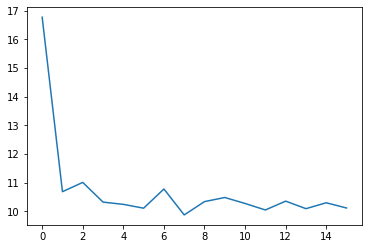

In [ ]:
import matplotlib.pyplot as plt
import pickle

with open(ROOT_PATH+'/pkl/unet_cifar10/unet_cifar10_loss.pkl','rb') as f:
    loss_list=pickle.load(f)
    
train_loss_list=loss_list[0]
plt.plot(train_loss_list)
plt.show()

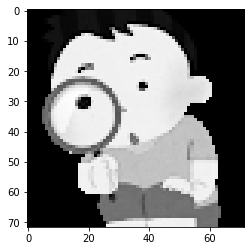

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


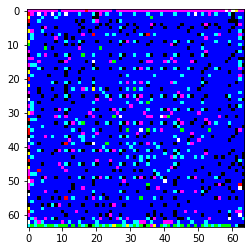

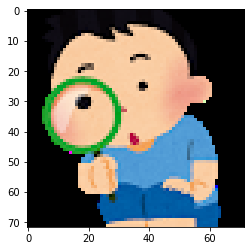

In [4]:
import matplotlib.pyplot as plt
import numpy
from common.util import to_cpu

id=np.random.randint(0,1000)

grey=x_test[id][0]
grey=to_cpu(grey)

plt.imshow(grey,cmap=plt.cm.Greys_r)
plt.show()


image=np.array([x_test[id]])
image=model.predict(image)
image=to_cpu(image)

image=image.transpose(0,2,3,1)
plt.imshow(image[0])
plt.show()

correct=t_test[id]
correct=to_cpu(correct)
correct=correct.transpose(1,2,0)

plt.imshow(correct)
plt.show()